# Welcome to the OceanSpy demo
<img src="https://github.com/malmans2/oceanspy/raw/master/docs/_static/oceanspy_logo_blue.png" width="50%" alt="OceanSpy">

Press `space` to continue.

In [ ]:
%%bash
# Download demo dataset.
# Shift+Enter to execute, then space for next slide
myurl="https://livejohnshopkins-my.sharepoint.com/"\
":u:/g/personal/malmans2_jh_edu/ETTi4yKjbvxOvraRKaydA3kBy_sOKNmkqGFP61CfsgW_bQ?"
wget -v -O tmp.tar.gz -L ${myurl}download=1 &&
tar xvzf tmp.tar.gz &&
rm -f tmp.tar.gz

# About OceanSpy

## What is OceanSpy?
A Python package to facilitate ocean model data analysis and visualization.

## Ocean circulation models are becoming increasingly realistic, producing:
*  Large volumes of data
*  Labelled multi-dimensional arrays
*  Arrays on staggered grids

## Ocean circulation models are becoming increasingly realistic, producing:
* Large volumes of data ⮕ [Dask](https://dask.org/)
* Labelled multi-dimensional arrays ⮕ [xarray](http://xarray.pydata.org/)
* Arrays on staggered grids ⮕ [xgcm](https://xgcm.readthedocs.io/)

### OceanSpy builds on software packages developed by the [Pangeo](https://pangeo.io/) community.
###### Pangeo tutorial @ 15:30

## Why OceanSpy? 
To analyze model data in the way observational oceanographers analyze field measurements.

<figure>
  <img src="https://journals.ametsoc.org/na101/home/literatum/publisher/ams/journals/content/bams/2019/15200477-100.9/bams-d-18-0217.1/20190923/images/large/bams-d-18-0217.1-f2.jpeg"
       width="80%" alt="IGP">
  <figcaption>Figure from Renfrew et al., 2019.</figcaption>
</figure>

## How to use OceanSpy?
* Locally with your own data.
* On remote data-analysis clusters with publicly available data (e.g., [SciServer](http://sciserver.org/) or clouds).

Check out https://oceanspy.readthedocs.io for instructions on how to import local datasets or access the datasets currently available on SciServer.

# Demo dataset

<figure>
  <img src="https://journals.ametsoc.org/na101/home/literatum/publisher/ams/journals/content/phoc/2017/15200485-47.12/jpo-d-17-0129.1/20171212/images/large/jpo-d-17-0129.1-f1.jpeg"
       width="80%" alt="model">
  <figcaption>Figure from Almansi et al., 2017.</figcaption>
</figure>

Setup

In [ ]:
# Import OceanSpy
import oceanspy as ospy

In [ ]:
# Import additional packages for plotting
# and change some defaults
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["figure.figsize"] = [10, 6]
mpl.rcParams["font.size"] = 15

# Hide warnings
import warnings

warnings.filterwarnings("ignore")

Open

In [ ]:
# Import oceandataset
od = ospy.open_oceandataset.from_zarr("OSM2020_EGshelfIIseas2km_ERAI_1D")

# Show oceandataset
print(od)

Plot bathymetry

In [ ]:
# Note that the plot is projected
# using the projection associated with od
od.plot.horizontal_section(varName="Depth")

# Use case: Kögur
<figure>
  <img src="http://kogur.whoi.edu/img/array2.png"
       width="50%" alt="Kogur" style="background-color: #1c4966;">
  <figcaption>From http://kogur.whoi.edu/</figcaption>
</figure>

## OceanSpy mooring array
<figure>
  <img src="https://oceanspy.readthedocs.io/en/latest/_images/Kogur_15_1.png"
       width="70%" alt="Kogur model">
  <figcaption>From https://oceanspy.readthedocs.io/en/latest/Kogur.html</figcaption>
</figure>

Extract mooring array

In [ ]:
# Kögur coordinates
lats_Kogur = [68.68, 67.52, 66.49]
lons_Kogur = [-26.28, -23.77, -22.99]

# Extract mooring array
od_moor = od.subsample.mooring_array(Xmoor=lons_Kogur, Ymoor=lats_Kogur)

Plot moorings

In [ ]:
# Show the array on top of bathymetry
ax = od.plot.horizontal_section(varName="Depth")
X, Y = od_moor.dataset["XC"].squeeze(), od_moor.dataset["YC"].squeeze()
ax.plot(X, Y, "r.", transform=ccrs.PlateCarree())

T/S diagram

In [ ]:
# T/S diagram color-coded by depth (averaged over time).
# Note that density needs to be computed.
od_moor.plot.TS_diagram(colorName="Z", meanAxes="time")

Animated T/S diagram

In [ ]:
# Using .animate instead of .plot
od_moor.animate.TS_diagram(colorName="Z")
plt.close()

## OceanSpy ship survey
<figure>
  <img src="https://web.whoi.edu/all0118/wp-content/uploads/sites/129/2019/02/aoY1Qa3w-1024x683.jpeg"
       width="60%" alt="survey">
  <figcaption>From https://web.whoi.edu/all0118</figcaption>
</figure>

Extract ship survey

In [ ]:
# Extract survey overlapping the mooring array
# Note that this function interpolates, getting rid of staggered grids
varList = ["Temp", "S", "U", "V"]
od_surv = od.subsample.survey_stations(
    Xsurv=lons_Kogur, Ysurv=lats_Kogur, delta=2, varList=varList
)

Show vertical section

In [ ]:
# Vertical section of temperature with isopycnals
od_surv.plot.vertical_section(
    varName="Temp",
    contourName="Sigma0",
    meanAxes="time",
    center=False,
    cmap="Spectral_r",
)

Rotate and show velocities

In [ ]:
# Switch reference system to cross/along-section
od_surv = od_surv.compute.survey_aligned_velocities()

# Animation of through section velocity
od_surv.animate.vertical_section(
    varName="ort_Vel", contourName="Sigma0", robust=True
)
plt.close()

# OceanSpy diagnostics overview
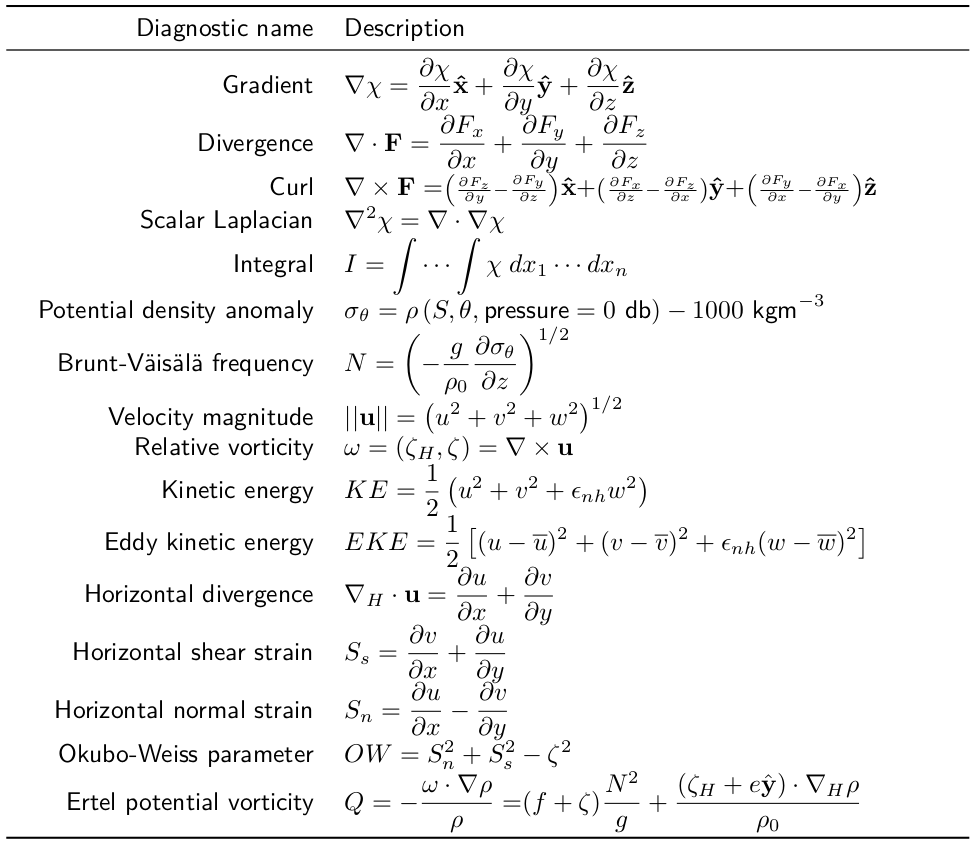
Table from Almansi et al., 2019.

Compute Ertel PV: $\displaystyle{Q = - \frac{\omega \cdot \nabla \rho}{\rho}  =}\displaystyle{(f + \zeta)\frac{N^2}{g} + \frac{\left(\zeta_H+e\hat{\mathbf{y}}\right)\cdot\nabla_H\rho}{\rho_0}}$

In [ ]:
# Compute Ertel PV in the top 100m
od100m = od.subsample.cutout(ZRange=[0, -100])
od100m = od100m.compute.Ertel_potential_vorticity()

Show Ertel PV evolution

In [ ]:
# Plot Ertel PV (averaged over Z).
# Note that the vertical mean is weighted by OceanSpy.
# Important because the vertical resolution of this model varies!
od100m.animate.horizontal_section(
    varName="Ertel_PV", meanAxes="Z", robust=True, center=False, cmap="inferno"
)
plt.close()

# More info:
* Documentation: https://oceanspy.readthedocs.io
* GitHub: https://github.com/malmans2/oceanspy
* JOSS paper: https://doi.org/10.21105/joss.01506